# Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. Задание имеет вид Peer-Review, так что творчество здесь активно приветствуется. Если задействуете IPython-виджеты, библиотеку Plotly, анимации и прочий интерактив, всем от этого будет только лучше.

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

## Часть 1. Построение признаков

In [50]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
import datetime

In [51]:
path_to_data = r'C:\Users\Диас\Desktop\DiaStudy\internet user identification\1 data preparation'

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [52]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    files = glob(path_to_csv_files + "/*.csv")
    
    with open(site_freq_path, 'rb') as f:
        site_freq = pickle.load(f)
    
    sessions = []
    
    for i, file in enumerate(files):
        time_stamp = pd.read_csv(file).iloc[:, 0]
        user_session = pd.read_csv(file).iloc[:, 1]
        
        cur_session = []
        cur_time = []
        index = 0
        
        while index < len(user_session):
            hour = float('inf')
            day = float('inf')
    
            for j in range(index, min(index + session_length, len(user_session))):
                cur_session.append(site_freq[user_session[j]][0])
                
                y, m, d = time_stamp[j].split()[0].split("-")
                day = min(day, datetime.date(int(y), int(m), int(d)).weekday())
                
                h, m, s = time_stamp[j].split()[1].split(":")
                hour = min(hour, int(h))
                
                cur_time.append(int(h) * 3600 + int(m) * 60 + int(s))
                
            time_diff = [cur_time[i] - cur_time[i - 1] for i in range(1, len(cur_time))]    
            unique_sites = len(list(dict.fromkeys(cur_session)))
            
            while len(cur_session) < session_length: cur_session.append(0)
            while len(time_diff) < session_length - 1: time_diff.append(0)
            
            timespan = sum(time_diff)
            sessions.append(cur_session + time_diff + [timespan, unique_sites, hour, day, i + 1])
            
            index += window_size
            cur_session = []
            cur_time = []
           
    df = pd.DataFrame(sessions)
    df.columns = feature_names
    
    return df

**Проверим функцию на игрушечном примере.**

In [53]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']

train_data_3users  = prepare_train_set_with_fe(os.path.join(path_to_data, '3users'), 
                                               site_freq_path=os.path.join(path_to_data, 'site_freq_3users.pkl'),
                                               feature_names=feature_names, session_length=10)

In [54]:
train_data_3users

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,10,8,8,4,8,5,1,6,2,9,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
1,10,5,5,5,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
2,10,8,3,3,8,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
3,7,5,8,5,8,5,5,6,11,7,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
4,7,5,8,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [55]:
session_len = 10
feature_names = ['site' + str(i) for i in range(1, session_len + 1)] + \
                ['time_diff' + str(j) for j in range(1, session_len)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']

In [56]:
%%time

train_data_10users = prepare_train_set_with_fe(os.path.join(path_to_data, '10users'), 
                                               site_freq_path=os.path.join(path_to_data, 'site_freq_10users.pkl'),
                                               feature_names=feature_names, session_length=session_len)

Wall time: 12.1 s


In [57]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1314,2306,4318,4172,4318,4318,4172,4318,2455,4318,10,0,0,1,20,1,0,1,0,33,5,8,4,1
1,4869,3050,2897,941,4318,206,252,1663,2354,3722,1,0,163,105,0,1,3,3,8,284,10,8,4,1
2,3722,4172,3722,3722,4104,3069,4869,2906,993,3722,0,14,1,242,0,0,1,0,0,258,7,8,4,1
3,370,1837,370,3722,3722,3722,3722,3589,3056,348,2,1,0,1,25,1,0,0,0,30,6,8,4,1
4,2993,3722,4104,1659,2336,2915,1759,629,1063,629,1,0,1,1,1,0,1,1,0,6,9,8,4,1


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [58]:
%%time

train_data_150users = prepare_train_set_with_fe(os.path.join(path_to_data, '150users'), 
                                                site_freq_path=os.path.join(path_to_data, 'site_freq_150users.pkl'),
                                                feature_names=feature_names, session_length=session_len)

Wall time: 1min 55s


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [59]:
new_features = ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']

In [60]:
new_features_10users = train_data_10users[new_features]
new_features_150users = train_data_150users[new_features]

In [61]:
with open('new_features_10users.pkl', 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
    
with open('new_features_150users.pkl', 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

## Часть 2. Визуальный анализ данных

**Забавы ради, для потехи дадим пользователям имена и ассоциируем с ними цвета.**

In [62]:
id_name_dict = {1: 'Mary-Kate', 2: 'Ashley', 3: 'Lindsey', 4: 'Naomi', 5: 'Avril',
               6: 'Bob', 7: 'Bill', 8: 'John', 9: 'Dick', 10: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [63]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

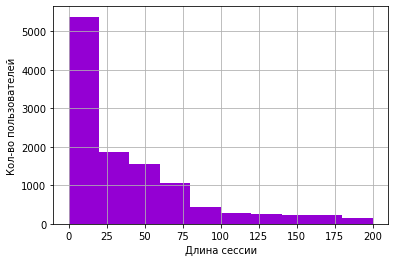

In [64]:
ax = train_data_10users['session_timespan'].plot(range=[0, 200], kind='hist', color='darkviolet', grid=True)
ax.set_xlabel("Длина сессии")
ax.set_ylabel("Кол-во пользователей");

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

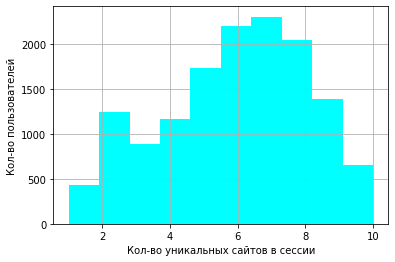

In [65]:
ax = train_data_10users['#unique_sites'].plot(kind='hist', color='aqua', grid=True)
ax.set_xlabel("Кол-во уникальных сайтов в сессии")
ax.set_ylabel("Кол-во пользователей");

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

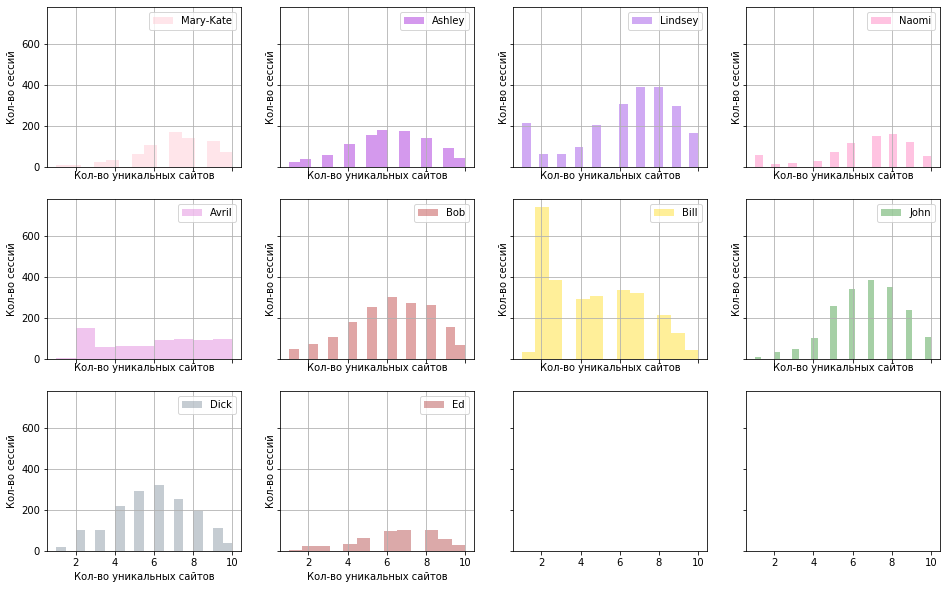

In [66]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10), sharey=True, sharex=True)

for i, name in enumerate(color_dic):
    sns.distplot(train_data_10users[train_data_10users['target'] == name]["#unique_sites"],
                 color = color_dic[name], ax=axes[i//4, i%4], kde=False, label=name)
    
    axes[i//4, i%4].set_xlabel("Кол-во уникальных сайтов")
    axes[i//4, i%4].set_ylabel("Кол-во сессий")
    axes[i//4, i%4].grid()
    axes[i//4, i%4].legend()

**6. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

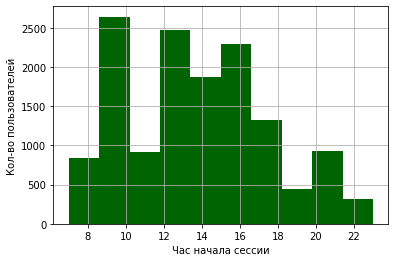

In [67]:
ax = train_data_10users['start_hour'].plot(kind = 'hist', color='darkgreen', grid=True)
ax.set_xlabel("Час начала сессии")
ax.set_ylabel("Кол-во пользователей");

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

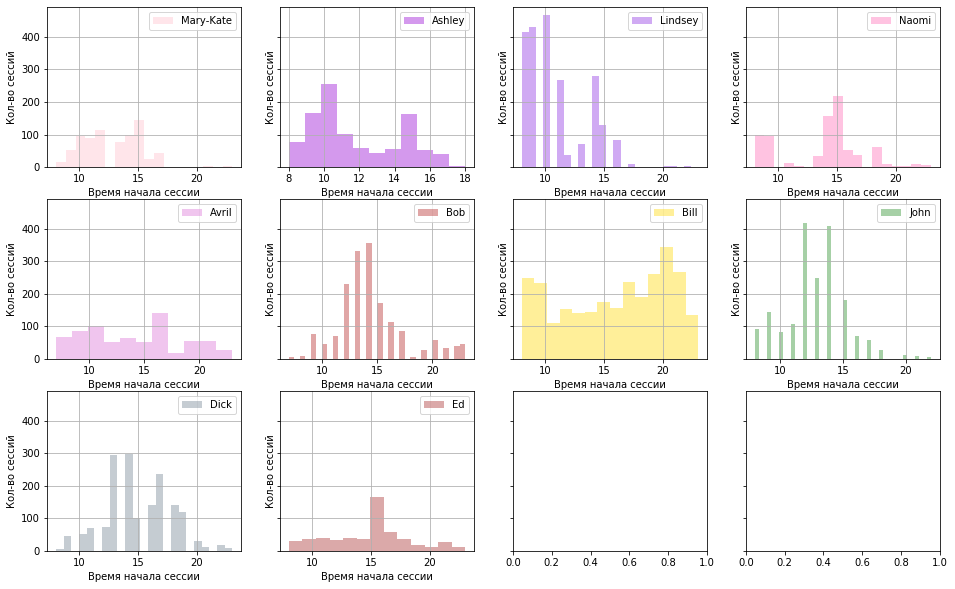

In [68]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10), sharey=True)

for i, name in enumerate(color_dic):
    sns.distplot(train_data_10users[train_data_10users['target'] == name]["start_hour"],
                 color = color_dic[name], ax=axes[i//4, i%4], kde=False, label=name)
    
    axes[i//4, i%4].set_xlabel("Время начала сессии")
    axes[i//4, i%4].set_ylabel("Кол-во сессий")
    axes[i//4, i%4].grid()
    axes[i//4, i%4].legend()

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

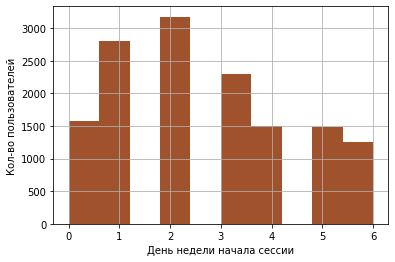

In [69]:
ax = train_data_10users['day_of_week'].plot(kind='hist', color='sienna', grid=True)
ax.set_xlabel("День недели начала сессии")
ax.set_ylabel("Кол-во пользователей");

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

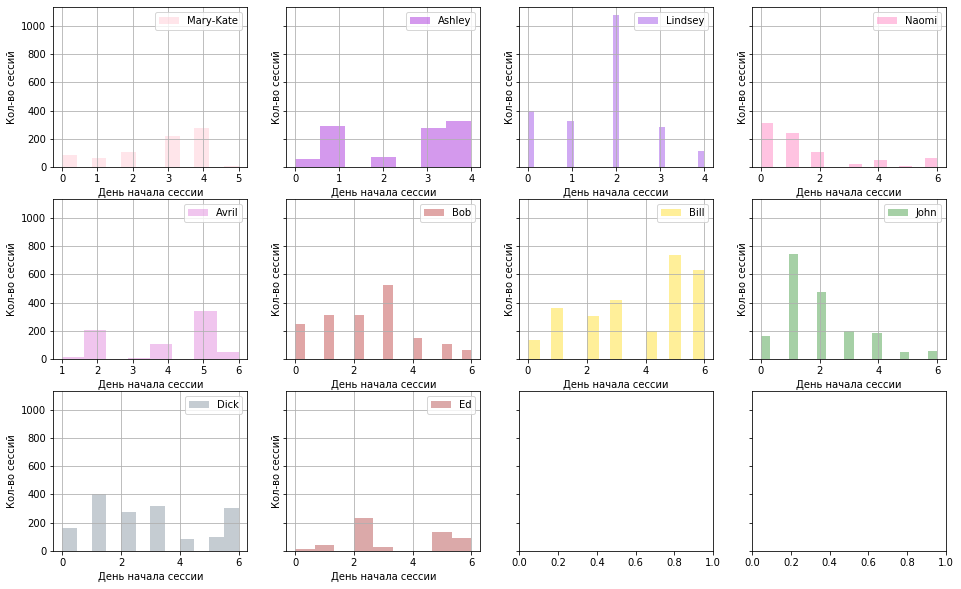

In [70]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10), sharey=True)

for i, name in enumerate(color_dic):
    sns.distplot(train_data_10users[train_data_10users['target'] == name]["day_of_week"],
                 color = color_dic[name], ax=axes[i//4, i%4], kde=False, label=name)
    
    axes[i//4, i%4].set_xlabel("День начала сессии")
    axes[i//4, i%4].set_ylabel("Кол-во сессий")
    axes[i//4, i%4].grid()
    axes[i//4, i%4].legend()

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

* Mary-Kate - в гистограмме уникальных сайтов в сессии преобладает значение 8, значений меньших 3 почти нет, либо очень мало. Из гафика "Время начала сессии" видно, что сессию в основном начинает в отрезке 10-12 либо же 14-15, на эти значения приходит пики. Что касается дня начала сессии, то пик приходится на 4-день.
* Ashley - в сессии в основном 6-7 уникальных сайтов, что видно из графика, затем идет спад. Время начала сессии в основном в 10 часов, также наблюдается ещё один пик в значении 15. Большая часть сессии начинаются во 3-4 дни недели, здесь пик.
* Lindsey - первый пик на графике количества уникальных сайтов наблюдается в значении 1, затем идет спад и пик 7-9. Время начала сессии большая часть в 9-10, затем спад и немного сессий сосредоточены в 14-15, после этого сессий вообще не было или очень мало. Пик дня начала сессии - 2-день.
* Naomi - в гистограмме уникальных сайтов в сессии преобладает значение 8. Пик начала сессий приходится на значение 15. Почти все сессии были начаты в начале недели, дальше идет спад.
* Avril - в основном 2-3 сайта в сессии, остальных значений немного меньше и они почти равномерно распределены. То же самое можно сказать и о времени начала сессии, небольшой пик в значении 16-17. Дни начала сессиий приходятся в основном на конец недели. 
* Bob - количество уникальных сайтов в сессии увеличивается при движении вправо, достигает своего пика в отрезке 6-7, затем снова убывает. Время начала сессии имеет почти нормальное распределение (немного тяжелые хвосты), с пиком в значении 14. На графике дня начала сессии пик в значении 3.
* Bill - больше всего 2 уникальных сайтов, затем идет резкий спад. График времени начала сессии почти равномерный с пиками в отрезках 9-10, 19-21. День начала сессии - большинство значений сосредоточены в 5-6. 
* John - график распределения количества уникальных частот имеет вид нормального распределения, за исключением того, что график немного скошен вправо, с пиком в 7. Что касается графика времени начала сессии, то оно-унимодальное с пиками в значениях 12 и 14. В графике "День начала сессии" виден резкий скачок в значении 1, затем постепенный спад.
* Dick - график распределения количества уникальных частот имеет вид нормального распределения с пиком в 6. График времени начала сессии с пиками в значениях 12 и 14. День начала сессии - небольшой пик в значении 1, в целом распределение в почти равномерное. 
* Ed - в целом у пользователя сравнительно мало сессий по сравнению с остальными, пик в значении 8. Время начала сессии резкий скачок в значении 15, остальные значения распределены равномерно. День начала сессии во 2-день.

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [71]:
with open(os.path.join(path_to_data, 'site_freq_10users.pkl'), 'rb') as f:
    site_freq = pickle.load(f)
    
site_freq = {site: site_freq[site][1] for site in site_freq}
site_freq = {site: site_freq[site] for site in sorted(site_freq, key=site_freq.get, reverse=True)}

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [72]:
top = 10

top10_sites = [site for site in site_freq][:top]
top10_freqs = [site_freq[site] for site in site_freq][:top]

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

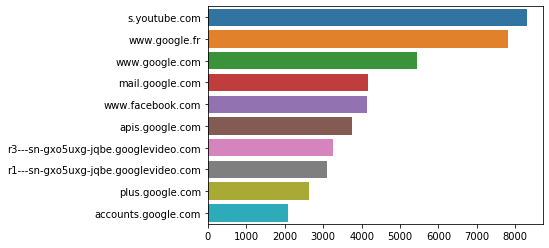

In [73]:
sns.barplot(top10_freqs, top10_sites);

## Часть 3. Проверка построенных признаков
Эта часть скорее техническая, смысл ее – убедиться, что мы все одинаково создали признаки *session_timespan, #unique_sites, start_hour* и *day_of_week*.

**10. Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [74]:
np.median(train_data_10users.session_timespan)

33.0

**11. Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [75]:
np.median(train_data_10users.day_of_week)

2.0

**12. Выведите медианный час начала сессии для сессий 150 пользователей.**

In [76]:
np.median(train_data_150users.start_hour)

13.0

**13. Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [77]:
np.median(train_data_150users['#unique_sites'])

7.0

## Часть 4. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [78]:
def feature_engineering(path_to_csv_files, path_to_dict, session_length=10, window_size=10):
    files = glob(path_to_csv_files + "/*.csv")
    
    with open(path_to_dict, 'rb') as f:
        site_freq = pickle.load(f)
    
    sessions = []
    
    for i, file in enumerate(files):
        time_stamp = pd.read_csv(file).iloc[:, 0]
        user_session = pd.read_csv(file).iloc[:, 1]
        
        cur_session = []
        cur_time = []
        index = 0
        
        while index < len(user_session):
            start_hour = float('inf')
            start_day_week = float('inf')
            
            start_day = float('inf')
            start_month = float('inf')
            start_year = float('inf')
            
            for j in range(index, min(index + session_length, len(user_session))):
                cur_session.append(site_freq[user_session[j]][0])
                
                year, month, day = time_stamp[j].split()[0].split("-")
                year, month, day = int(year), int(month), int(day)
                
                start_day_week = min(start_day, datetime.date(year, month, day).weekday())
                start_day = min(start_day, day)
                start_month = min(start_month, month)
                start_year = min(start_year, year)
                
                hour, minute, second = time_stamp[j].split()[1].split(":")
                hour, minute, second = int(hour), int(minute), int(second)
                start_hour = min(start_hour, hour)
                
                cur_time.append(hour * 3600 + minute * 60 + second)
                
            time_diff = [cur_time[i] - cur_time[i - 1] for i in range(1, len(cur_time))]    
            unique_sites = len(dict.fromkeys(cur_session))
            
            while len(cur_session) < session_length: cur_session.append(0)
            while len(time_diff) < session_length - 1: time_diff.append(0)
            
            time_info = [start_hour, np.sum(time_diff), np.mean(cur_time)]
            date_info = [start_day_week, start_day, start_month, start_year]
            
            sessions.append(cur_session + time_diff + time_info + [unique_sites] + date_info + [i + 1])
            
            index += window_size
            cur_session = []
            cur_time = []
            
    df = pd.DataFrame(sessions)
    feature_names = ['site' + str(i) for i in range(1, session_length + 1)] + \
                    ['time_diff' + str(j) for j in range(1, session_length)] + \
                    ['start_hour', 'session_timespan', 'avg_time', '#unique_sites',
                    'day_week', 'day', 'month', 'year', 'target']
    
    df.columns = feature_names
    return df

In [79]:
%%time

new_features_10users = feature_engineering(os.path.join(path_to_data, '10users'), 
                                           os.path.join(path_to_data, 'site_freq_10users.pkl'))

Wall time: 11.9 s


In [80]:
%%time

new_features_150users = feature_engineering(os.path.join(path_to_data, '150users'), 
                                            os.path.join(path_to_data, 'site_freq_150users.pkl'))

Wall time: 1min 59s


In [81]:
new_features = ['avg_time', 'day', 'month', 'year']

**14. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

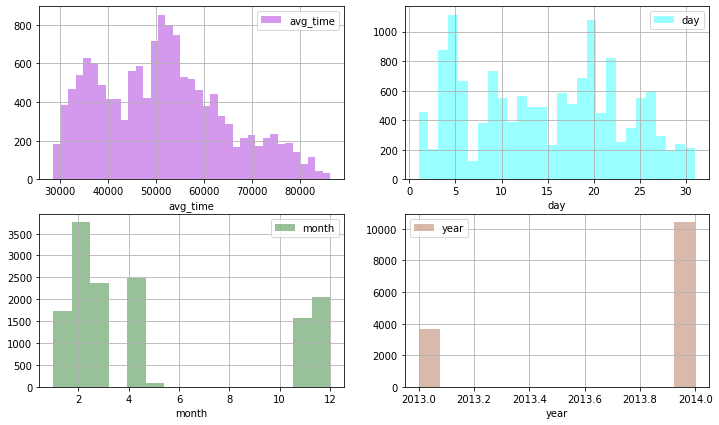

In [82]:
colors = ['darkviolet', 'aqua', 'darkgreen', 'sienna']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 7))

for i, feature in enumerate(new_features):
    sns.distplot(new_features_10users[feature], ax=axes[i//2, i%2], 
                 kde=False, label=feature, color=colors[i])
    axes[i//2, i%2].grid()
    axes[i//2, i%2].legend()

1. Средняя продолжительность сессии в секундах - пик приходится примерно на 52 000 - 54 000 секунд, затем идет спад. Второй пик 30 000 - 40 000 секунд.
2. День начала сессии - здесь также видим, что значения распределены примерно равномерно. Первый пик в числах 4-5, затем идет резкий спад, второй пик 19-20
3. Месяц начала сессии - по графику видно, что сессии в основном начинались в феврале, т.к. большинство значений сосредоточены во 2-месяце. Следут идут апрель и конец осени.
4. Год начала сессии - почти все сессии начались в 2014-годы, лишь немногие в 2013.

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [83]:
selected_features_10users = ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week', 'avg_time', 'day'] 
selected_features_150users = ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week', 'avg_time', 'day'] 

In [84]:
with open('selected_features_10users.pkl', 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, protocol=2)

with open('selected_features_150users.pkl', 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, protocol=2)

## Критерии оценки работы:
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)